# 0. Download Packages

In [1]:
import os
import sys
import math
import random
import pickle
import warnings
import matplotlib.dates as mdates

from datetime import datetime, timedelta
from bisect import bisect_left
from itertools import combinations
from math import sqrt

import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.tseries.offsets import MonthEnd
from matplotlib.patches import Rectangle

from scipy import stats
from scipy.stats import (norm, skew, kurtosis, pearsonr, spearmanr, kendalltau)
from scipy.optimize import curve_fit

from sklearn.metrics import mean_squared_error

import pysal
from numpy.random import Generator, PCG64
from functools import partial


file = "C:/Users/jarra/Desktop/RA ASSISTANT/FINALISED/"

import sys
sys.path.append(file)

import nbimporter
import FUNCTION_LIST as ChatJR # This will import all top-level functions/definitions from the notebook



In [2]:
# 1. DOWNLOAD DATA

In [3]:
'''OVERALL PERTH PRESSURE DATASETS Pressure'''
PERTH_SUBDAILY = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_METRO_PRESSURE_CORRECTED_SUBDAILY_1830-2024.csv").set_index('Date')
PERTH_SUBDAILY.index= pd.to_datetime(PERTH_SUBDAILY.index,format='mixed',dayfirst = True)

PERTH_MONTHLY = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_METRO_PRESSURE_CORRECTED_MONTHLY_1830-2024.csv").set_index('Date')
PERTH_MONTHLY.index= pd.to_datetime(PERTH_MONTHLY.index,format='mixed',dayfirst = True)

PERTH_YEARLY = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_METRO_PRESSURE_CORRECTED_YEARLY_1830-2024.csv").set_index('Date')
PERTH_YEARLY.index= pd.to_datetime(PERTH_YEARLY.index,format='mixed',dayfirst = True)


In [4]:
## CAPE OTWAY


In [5]:
'''CAPE OTWAY PRESSURE'''
CAPE_OTWAY_PRES = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\CAPE_OTWAY_PRESSURE_MSLP_TRANSCRIBED_DAILY_1861_2021.csv")
CAPE_OTWAY_PRES['Date'] = pd.to_datetime(CAPE_OTWAY_PRES['idx'],format ='mixed',dayfirst = True)
CAPE_OTWAY_PRES =CAPE_OTWAY_PRES[['Date','slp']]
CAPE_OTWAY_PRES.set_index('Date',inplace = True)
CAPE_OTWAY_DAILY = CAPE_OTWAY_PRES

CAPE_OTWAY_DAILY.rename(columns = {'slp':'MSLP'}, inplace= True)
CAPE_OTWAY_DAILY

,MSLP
Date,
1861-01-11,1011.05
1861-01-12,1014.40
1861-01-13,1018.40
1861-01-14,1021.45
1861-01-15,1018.30
...,...
2021-08-14,1024.82
2021-08-15,1018.43
2021-08-16,1021.19


In [6]:
'''Pressure'''
CO = pd.read_fwf(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\CAPE_OTWAY_PRESSURE_BOM_SUBDAILY_2021_2024.txt", colspecs=[(1, 7), (7, 20), (27, 33), (35, 41)], 
                   header=None, names=['ID', 'Date', 'MSLP', 'Pressure'])

# Ensure Date column is in the correct format
CO['Date'] = pd.to_datetime(CO['Date'], format='%Y%m%d%H%M')
CO['Pressure'] =CO['Pressure']/10
CO['MSLP'] =CO['MSLP']/10

CO.set_index('Date',inplace =True)
CO = CO[['MSLP']]
CO = CO.resample('D').mean().round(2)

CAPE_OTWAY_DAILY = pd.concat([CAPE_OTWAY_DAILY, CO.loc['2021-08-19':'2024-12-31']],axis = 0).round(1)

## CAPE LEEUWIN


In [7]:
'''CAPE LEEUWIN PRESSURE'''
CAPE_LEEUWIN_PRES = pd.read_fwf(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\CAPE_LEEUWIN_PRESSURE_BOM_SUBDAILY_1907_2024.txt", colspecs=[(1, 7), (8, 20), (26, 32), (34, 40)], 
                  header=None, names=['ID', 'Date', 'MSLP', 'Station Pressure'])

# Ensure Date column is in the correct format
CAPE_LEEUWIN_PRES['Date'] = pd.to_datetime(CAPE_LEEUWIN_PRES['Date'], format='%Y%m%d%H%M')


CAPE_LEEUWIN_PRES['MSLP'] =CAPE_LEEUWIN_PRES['MSLP']/10
CAPE_LEEUWIN_PRES['Station Pressure'] =CAPE_LEEUWIN_PRES['Station Pressure']/10

CAPE_LEEUWIN_PRES.set_index('Date',inplace =True)
CAPE_LEEUWIN_SP = CAPE_LEEUWIN_PRES[['Station Pressure']]

CAPE_LEEUWIN_PRES = CAPE_LEEUWIN_PRES[['MSLP']]
CAPE_LEEUWIN_PRES = CAPE_LEEUWIN_PRES[CAPE_LEEUWIN_PRES['MSLP']<1050]
CAPE_LEEUWIN_MSLP_BOM = CAPE_LEEUWIN_PRES[CAPE_LEEUWIN_PRES['MSLP']>950]

CAPE_LEEUWIN_SP = CAPE_LEEUWIN_SP[CAPE_LEEUWIN_SP['Station Pressure']<1050]
CAPE_LEEUWIN_STATION_PRESSURE = CAPE_LEEUWIN_SP[CAPE_LEEUWIN_SP['Station Pressure']>950]

In [8]:
CAPE_LEEUWIN_TEMP = pd.read_fwf(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\CAPE_LEEUWIN_TEMPERATURE_BOM_SUBDAILY_1907_2024.txt", colspecs=[(1, 7), (8, 20), (27, 30), (38, 41)], 
                  header=None, names=['ID', 'Date', 'degC', 'Dew Point'])
CAPE_LEEUWIN_TEMP['degC'] =CAPE_LEEUWIN_TEMP['degC']/10
CAPE_LEEUWIN_TEMP['Date'] = pd.to_datetime(CAPE_LEEUWIN_TEMP['Date'], format='%Y%m%d%H%M')

CAPE_LEEUWIN_TEMPERATURE  = CAPE_LEEUWIN_TEMP[['Date','degC']].set_index('Date')
CAPE_LEEUWIN_TEMPERATURE

,degC
Date,
1907-01-01 09:00:00,19.4
1907-01-01 15:00:00,23.5
1907-01-02 09:00:00,17.5
1907-01-02 15:00:00,22.0
1907-01-03 09:00:00,19.2
...,...
2024-12-16 04:00:00,17.5
2024-12-16 05:00:00,17.7
2024-12-16 06:00:00,17.6


In [9]:
CAPE_LEEUWIN_TEMPERATURE.loc['1939-07']

,degC
Date,
1939-07-11 09:00:00,13.1
1939-07-11 15:00:00,15.6
1939-07-12 09:00:00,12.9
1939-07-12 15:00:00,17.2
1939-07-13 09:00:00,13.6
1939-07-13 15:00:00,15.6
1939-07-14 09:00:00,14.7
1939-07-14 15:00:00,15.6
1939-07-15 09:00:00,12.5


In [10]:
'''Pressure'''
CL = pd.read_fwf(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\CAPE_LEEUWIN_PRESSURE_BOM_SUBDAILY_2021_2024.txt", colspecs=[(1, 7), (7, 20), (27, 33), (35, 41)], 
                   header=None, names=['ID', 'Date', 'MSLP', 'Pressure'])

# Ensure Date column is in the correct format
CL['Date'] = pd.to_datetime(CL['Date'], format='%Y%m%d%H%M')
CL['Pressure'] =CL['Pressure']/10
CL['MSLP'] =CL['MSLP']/10

CL.set_index('Date',inplace =True)
CL_MSLP = CL[['MSLP']]




CAPE_LEEUWIN_MSLP_BOM = pd.concat([CAPE_LEEUWIN_MSLP_BOM, CL_MSLP.loc['2024-11-29 09:00:00':'2024-12-31']],axis = 0)

# 3. LIST ALL METADATA CHANGES

## CAPE OTWAY

One of the major issues we have with CO is that there is no concrete metadata to help figure out why there is a dip in pressure in the 1890s. We have idetified differences in the way the data was recorded over those months, but these are used more as secondary and tertiery verifications tools to help find the precise date changes to the instrument or the way the data was recorded occurs. Therefore, until we know more information, we are unable to use the Type 0 changes to fix up the record. Thus we solely rely on the Type 1 cahnges that are captured in the monthly record and subsequently update the daily record with these known changes. 

The only real valubale evidence to support that something unnatural had indeed changed was the retired of a guy who loved pressure and following the minilistic approach on the monthly recaps for information after June 1892. -> Say it more detailed etc

## CAPE LEEUWIN

"Equipment history updated to correspond to climate data in ADAM and Station File Part 2 dating back to 1984. For unknown reason it appears that the history was deleted from SitesDB at some stage. To Note: Max and Min data in ADAM are only monthly averages until January 1907. Rainfall is only monthly data in ADAM until February 1903. Exact date of cease of barograph is unknown at this stage WOT equipment history not included at this stage - VM."

"Going through the files – first find is a 1919 reference to the barometer being placed "upstairs" (and the lightkeeper expressing some displeasure about having to climb 176 stairs to read it)."

"A famous maritime landmark and important meteorological site from which data is collected, the tower stands 39 metres high from ground level and 56 metres above sea level."

"this is what I found, and also 176 stairs the total number of stairs so its around 50m above sea level if they have measured the height from the complete top of the lighthouse"

"And I found the following in the metadata:
Relocation from 159 feet to 71 feet on 22/11/1937
Barometer height of 23m as of 5/1/1977 (implying either a resurvey or a small move at some point between 1937 and 1977, but probably not enough to be significant).
Present height is 14m."

"Thanks. That looks consistent with a move date on or close to 22/5/1979 (and definitely later than February 1979) – one document gave that date but another implied it may have happened around when the screen moved (November 1978)."


"Ok that's great to know, likely they moved the Kew Pattern barometer a few months after the screen was moved"

"Yes, they were separate moves (the barometer was moved from the bottom of the lighthouse to a hut near the new site)."








Hi Blair, 

If you have some time today, do you mind helping me infill the rest of the metadata required for getting the station pressure to MSLP?

---------------------------------


1907-01 TO 1937-11-21 |||| Barometer Height Sea Level: 159ft ||| latitude coordinate: -34.3749 ||| Barometer Type: Kew Pattern 

Location and Height Change

1937-11-22 TO 1979-5-21 |||| Barometer Height Sea Level: 23.2m ||| latitude coordinate:  -34.3737  ||| Barometer Type: Kew Pattern 

Location and Height Change (250m move but coordinates needed, do you think its always 23m height from 1979 to 1999) 

1979-5-22 TO 1993-02-02 |||| Barometer Height Sea Level: 14.2 ||| latitude coordinate:  -34.3737  ||| Barometer Type:  Kew Pattern    

Barometer Type Change (To Automatic)

1993-02-03 TO 1999-03 |||| Barometer Height Sea Level: 14.2  ||| latitude coordinate:  -34.3737  ||| Barometer Type: Automatic Vaisala PA11A S/N

Location and Height Change (WNW move)

1999-04 TO 2001-05-01 |||| Barometer Height Sea Level: 14m ||| latitude coordinate:  -34.3728  ||| Barometer Type: Automatic Vaisala PA11A S/N

Barometer Type Change

2001-05-02 TO 2011-7-12 |||| Barometer Height Sea Level: 14m ||| latitude coordinate:  -34.3728  ||| Barometer Type: Automatic Vaisala PA11A S/N

Barometer Type Change

2011-7-12  TO 2024-12 |||| Barometer Height Sea Level: 14m ||| latitude coordinate:  -34.3728  ||| Barometer Type: Automatic Vaisala PTB220B S/N


---------------

This is all the definite information I have on Cape Leeuwin based off information from your emails and the metadata on the BoM website,

I hope you had a good weekend, it's a hot one today!

Kind regards Jarrad











Jarrad,

 

Got some long-running code going so a good time to do emails 😊.

 

The barometer height change from 23.2 to 14.2m occurred with the 1979 move. It's now recorded as 14m, it would seem logical that this occurred when the AWS was installed in 1993 and there would have no longer been a separate barometer but I haven't seen hard evidence of this (and in any case its impact on the observations would be negligible).

 

The question mark is then, we have a barometer height of 21.6m after the 1937 move and 23.2m before the 1979 move, but did the instrument actually move or was this a resurvey at some point? The images I've seen suggest the barometer was at the ground level of the lighthouse throughout the 1937-1979 period but I couldn't rule out that it might have moved within that space. Nevertheless for now I'd probably be inclined to assume 23.2m through the 1937-1979 period unless/until evidence emerges to the contrary.

 

As for coordinates – the first thing to note here are that the coordinates which are recorded (when they are recorded) are those of the main observing site (I think nominally it's the rain gauge), not those of the barometer if it's in a separate location. Hence even if all the metadata were digitised, the pre-1979 coordinates would not be those of the lighthouse.

 

I've attached the Google image of the area (the red marker is the current site). I did some playing around with Google and it looks like the approximate coordinates of the lighthouse are -34.3750, 115.1363.














Cape Leeuwin Barometer Timeline
1907-01 to 1937-11-21
Barometer Height (ASL): 159 ft (48.5 m)
Latitude: -34.3749
Barometer Type: Kew Pattern
Location: Lighthouse

1937-11-22 to 1979-05-21
Barometer Height (ASL): 23.2 m (assumed constant, despite conflicting 21.6 m reference)
Latitude: Approx. -34.3750, 115.1363 (Lighthouse location)
Barometer Type: Kew Pattern
Notes: Possible resurvey rather than an actual move.

1979-05-22 to 1993-02-02
Barometer Height (ASL): 14.2 m
Latitude: Approx. -34.3728 (New site after 250m WNW move)
Barometer Type: Kew Pattern
Notes: Barometer moved from lighthouse to hut near new site.

1993-02-03 to 1999-03
Barometer Height (ASL): 14.2 m
Latitude: -34.3728
Barometer Type: Automatic Vaisala PA11A S/N
Notes: Barometer type changed to automatic.

1999-04 to 2001-05-01
Barometer Height (ASL): 14 m
Latitude: -34.3728
Barometer Type: Automatic Vaisala PA11A S/N
Notes: Minor height adjustment recorded.

2001-05-02 to 2011-07-12
Barometer Height (ASL): 14 m
Latitude: -34.3728
Barometer Type: Automatic Vaisala PA11A S/N
Notes: No significant changes recorded.

2011-07-12 to 2024-12
Barometer Height (ASL): 14 m
Latitude: -34.3728
Barometer Type: Automatic Vaisala PTB220B S/N
Notes: New barometer type installed.

Relocation from 159 feet to 71 feet on 22/11/1937

1907-01 TO 1937-11-21 |||| Barometer Height Sea Level: 159ft ||| latitude coordinate: -34.3749 ||| Barometer Type: Kew Pattern 

1937-11-22 TO 1979-5-21 |||| Barometer Height Sea Level: 71ft ||| latitude coordinate:  -34.3737  ||| Barometer Type: Kew Pattern 

1979-5-22 TO 1993-02-02 |||| Barometer Height Sea Level: 14.2 ||| latitude coordinate:  -34.3737  ||| Barometer Type:  Kew Pattern    

Barometer height of 23m as of 5/1/1977 (implying either a resurvey or a small move at some point between 1937 and 1977, but probably not enough to be significant).
Present height is 14m."


"Thanks. That looks consistent with a move date on or close to 22/5/1979 (and definitely later than February 1979) – one document gave that date but another implied it may have happened around when the screen moved (November 1978)."

#####################################

Barometer Type Change (To Automatic)

1993-02-03 TO 1999-03 |||| Barometer Height Sea Level: 14m  ||| latitude coordinate:  -34.3737  ||| Barometer Type: Automatic Vaisala PA11A S/N

Location and Height Change (WNW move)

1999-04 TO 2001-05-01 |||| Barometer Height Sea Level: 14m ||| latitude coordinate:  -34.3728  ||| Barometer Type: Automatic Vaisala PA11A S/N

Barometer Type Change

2001-05-02 TO 2011-7-12 |||| Barometer Height Sea Level: 14m ||| latitude coordinate:  -34.3728  ||| Barometer Type: Automatic Vaisala PA11A S/N

Barometer Type Change

2011-7-12  TO 2024-12 |||| Barometer Height Sea Level: 14m ||| latitude coordinate:  -34.3728  ||| Barometer Type: Automatic Vaisala PTB220B S/N


Basically, we will update with our data up till 1993, then I will take the MSLP from the automatic era to use as the MSLP. this should give us the best estimation of the pressure in this period

# 3. CORRECT ALL DATASETS TO AS READ TO MSLP

## CAPE LEEUWIN BOM AS READ TO MSLP

<Axes: xlabel='Date'>

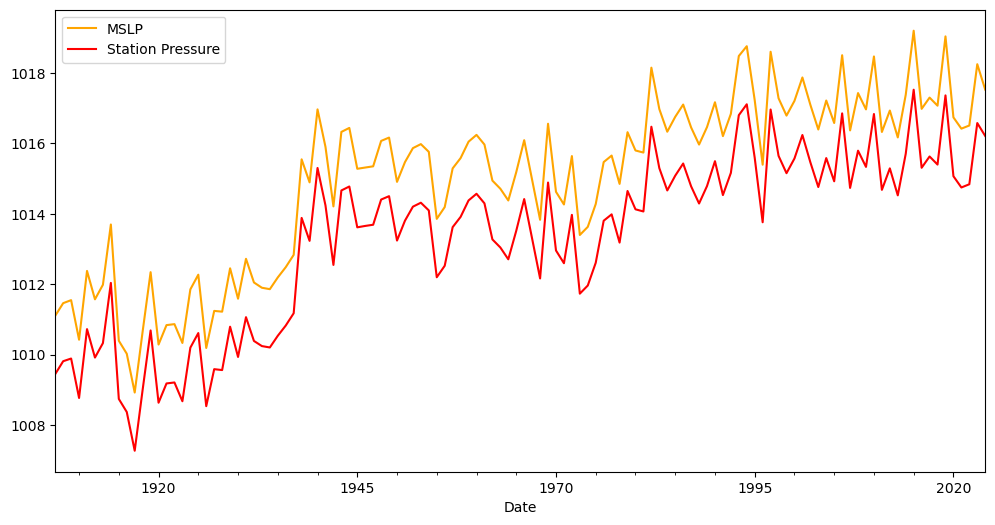

In [11]:
fig, ax= plt.subplots(1, 1, figsize=(12, 6), sharex=True)

CAPE_LEEUWIN_MSLP_BOM.resample('YS').mean().plot(ax = ax,color = 'orange')
CAPE_LEEUWIN_STATION_PRESSURE.resample('YS').mean().plot(ax = ax,color = 'red')

In [12]:
CAPE_LEEUWIN_MSLP = CAPE_LEEUWIN_MSLP_BOM.loc['1993-02-03':]

In [13]:
CLSP_TO_UPDATE = CAPE_LEEUWIN_STATION_PRESSURE.loc[:'1993-02-02']
CLSP_T_TO_UPDATE = CAPE_LEEUWIN_TEMPERATURE.loc[:'1993-02-02']

In [14]:
                                                    
CAPE_LEEUWIN_SP_1907_1937 = ChatJR.Reduce_to_MSLP_V2_2(CLSP_TO_UPDATE.loc[:'1937-11-21'], CLSP_T_TO_UPDATE.loc[:'1937-11-21'], 'Kew', 'hPa', 'degC', -34.3749, 159, 'ft')
CAPE_LEEUWIN_SP_1937_1979 = ChatJR.Reduce_to_MSLP_V2_2(CLSP_TO_UPDATE.loc['1937-11-22':'1979-05-21'], CLSP_T_TO_UPDATE.loc['1937-11-22':'1979-05-21'], 'Kew', 'hPa', 'degC', -34.3749 , 23.2, 'm') #71ft but dont know the date this occurred but before 1977
CAPE_LEEUWIN_SP_1979_1993 = ChatJR.Reduce_to_MSLP_V2_2(CLSP_TO_UPDATE.loc['1979-05-22':'1993-02-02'], CLSP_T_TO_UPDATE.loc['1979-05-22':'1993-02-02'], 'Kew', 'hPa', 'degC', -34.3727 , 14, 'm')

#automatics are already adjusted DUE TO THE INTENSE CALIBRATION IN THE SOFTWAY, SO WE ONLY NEED TO UPDATE THE ORIGINAL SO MSLP WOULD ACCOUNT FOR
#THE MOVE, THE LOCATION, THE EHIGHT, AND THE TEMEPRATURE


CAPE_LEEUWIN_MSLP = pd.concat([CAPE_LEEUWIN_SP_1907_1937,CAPE_LEEUWIN_SP_1937_1979,CAPE_LEEUWIN_SP_1979_1993,CAPE_LEEUWIN_MSLP],axis = 0).sort_index()[['MSLP']]



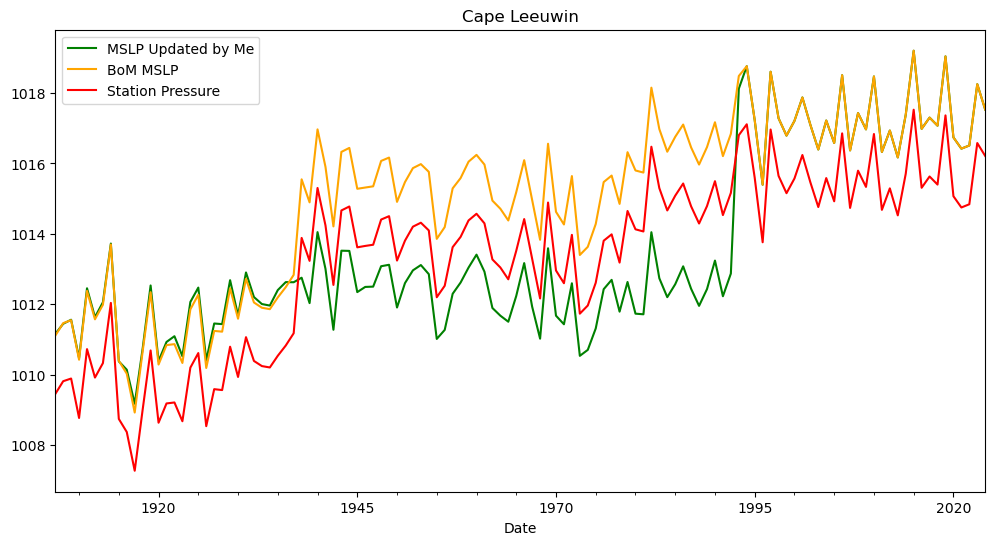

In [15]:
fig, ax= plt.subplots(1, 1, figsize=(12, 6), sharex=True)
CAPE_LEEUWIN_MSLP['MSLP'].resample('YS').mean().plot(ax = ax,color = 'green')
CAPE_LEEUWIN_MSLP_BOM.resample('YS').mean().plot(ax = ax,color = 'orange')
CAPE_LEEUWIN_STATION_PRESSURE.resample('YS').mean().plot(ax = ax,color = 'red')
ax.legend(['MSLP Updated by Me','BoM MSLP','Station Pressure'])
ax.set_title('Cape Leeuwin')
fig.savefig(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\FIGURES\Cape Leeuwin MSLP Comparison.png", dpi=300, bbox_inches='tight')


## CAPE OTWAY

NO NEED TO UPDATE THIS, AS WE DONT HAVE TEMPERATURES OR AS READ PRESSURE AVALIABLE 

# 4. ADJUST FOR DAYLIGHT SAVINGS

In [16]:

# Extract all 0th-hour data
Extract_0 = CAPE_LEEUWIN_MSLP[CAPE_LEEUWIN_MSLP.index.hour == 0]
CAPE_LEEUWIN_MSLP = CAPE_LEEUWIN_MSLP[CAPE_LEEUWIN_MSLP.index.hour != 0]

# Start with the filtered dataset
filtered = CAPE_LEEUWIN_MSLP.copy()

# Define the ranges to exclude
exclusion_ranges = [
    ['1974-10-27 08:00:00', '1975-03-02'],
    ['1983-10-30 02:00:00', '1984-03-04'],
    ['1991-11-17 02:00:00', '1992-03-01'],
    ['2006-12-03 02:00:00', '2007-03-25'],
    ['2007-10-28 02:00:00', '2008-03-30'],
    ['2008-10-26 02:00:00', '2009-03-29'],
]

# Remove rows from these ranges
for start, end in exclusion_ranges:
    date_range = pd.date_range(start=start, end=end, freq='H')
    filtered = filtered[~filtered.index.isin(date_range)]

# Adjust for shifted ranges and add them back
adjusted_ranges = [
    ['1974-10-27 08:00:00', '1975-03-01'],
    ['1983-10-30 02:00:00', '1984-03-03'],
    ['1991-11-17 02:00:00', '1992-02-29'],
    ['2006-12-03 02:00:00', '2007-03-24'],
    ['2007-10-28 02:00:00', '2008-03-29'],
    ['2008-10-26 02:00:00', '2009-03-28'],
]

for start, end in adjusted_ranges:
    Change = CAPE_LEEUWIN_MSLP.loc[start:end].shift(freq='1H')
    filtered = pd.concat([filtered, Change], axis=0)

# Add back the 0th-hour data
filtered = pd.concat([filtered, Extract_0], axis=0)

# Sort the final dataset
filtered = filtered.sort_index()

# Assign back to the original variable
CAPE_LEEUWIN_MSLP = filtered

CAPE_LEEUWIN_MSLP = CAPE_LEEUWIN_MSLP.sort_index()

C:\Users\jarra\AppData\Local\Temp\ipykernel_49800\3992724540.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start, end=end, freq='H')
C:\Users\jarra\AppData\Local\Temp\ipykernel_49800\3992724540.py:34: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  Change = CAPE_LEEUWIN_MSLP.loc[start:end].shift(freq='1H')


In [17]:
CAPE_LEEUWIN_MSLP.loc['1984-03-04']

,MSLP
Date,
1984-03-04 09:00:00,1006.77
1984-03-04 15:00:00,1005.34


# 5. RH-TEST ALL DATASETS

## CAPE LEEUWIN

In [18]:
CAPE_LEEUWIN_MSLP[CAPE_LEEUWIN_MSLP.index.duplicated(keep=False)].dropna()# keep=False keeps all duplicates


,MSLP
Date,


In [19]:
outpath = "C:/Users/jarra/Desktop/RA ASSISTANT/FINALISED/PART_2_RHTESTING/CAPE LEEUWIN/"


PER_M = ChatJR.rh_fmt_row_month_mean_via_WMO_Guide(CAPE_LEEUWIN_MSLP.resample('D').mean())
PER_M.to_csv(outpath + f'CL_M_' + str(PER_M['year'][0]) + '-' + str(PER_M['year'].iloc[-1]) + '.dat', sep=' ', index=False, header=False)

for i in range(0,24):
    PER_M = ChatJR.rh_fmt_row_month_mean_via_WMO_Guide(CAPE_LEEUWIN_MSLP[CAPE_LEEUWIN_MSLP.index.hour == i])
    PER_M.to_csv(outpath + f'CL_M{i}_' + str(PER_M['year'][0]) + '-' + str(PER_M['year'].iloc[-1]) + '.dat', sep=' ', index=False, header=False)


    #Subdaily Datasets
    PER_D = ChatJR.rh_fmt_row_day_mean(CAPE_LEEUWIN_MSLP[CAPE_LEEUWIN_MSLP.index.hour == i])
    PER_D.to_csv(outpath + f'CL_D{i}_' + str(PER_D['year'][0]) + '-' + str(PER_D['year'].iloc[-1]) + '.dat', sep=' ', index=False, header=False)
    

FUNCTION_LIST.ipynb:89: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  "    - months (list of int): List of months to filter for (e.g., [1, 2, 3] for Jan, Feb, Mar).\n",
FUNCTION_LIST.ipynb:89: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  "    - months (list of int): List of months to filter for (e.g., [1, 2, 3] for Jan, Feb, Mar).\n",
FUNCTION_LIST.ipynb:89: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longe

### Monthly as a guide


CHANGES
1907-01-01 START

1937-12 HEIGHT CHANGE

1940-01 BARO CHANGE

1979-06 HEIGHT CHANGE AND LOCATION

1987-04 BARO CHANGE

1993-02 - BARO CHANGE

1999-04 BAROMETER CHANGE AND LOCATION

2001-05 BAROMETER CHANGE

2011-07 


In [20]:
'''
10 changepoints in Series C:/Users/jarra/Desktop/RA ASSISTANT/FINALISED/PART_2_RHTESTING/CAPE LEEUWIN/CL_M_1907-2024.dat 
1 Yes   19281000 (    1.0000-    1.0000) 0.950   19.9102 (   12.4315-   15.1712)
0 No    19371200 (    0.2111-    0.2521) 0.950    0.1267 (   11.8634-   14.4172)
0 No    19400100 (    0.7793-    0.7867) 0.950    1.4076 (   12.5189-   15.2969)
0 No    19790600 (    0.4495-    0.4753) 0.950    0.4196 (   12.5219-   15.3012)
1 No    19811100 (    0.9903-    0.9905) 0.950    7.1158 (   11.6308-   14.1036)
0 No    19870400 (    0.1241-    0.1278) 0.950    0.0266 (   11.8634-   14.4172)
0 Yes   19930100 (    1.0000-    1.0000) 0.950  161.8479 (   11.9122-   14.4828)
0 No    19990300 (    0.5287-    0.5405) 0.950    0.5285 (   11.6710-   14.1586)
0 No    20010500 (    0.6030-    0.6090) 0.950    0.7380 (   11.9339-   14.5119)
0 No    20110700 (    0.7512-    0.7524) 0.950    1.3376 (   12.3355-   15.0365)
'''


'\n10 changepoints in Series C:/Users/jarra/Desktop/RA ASSISTANT/FINALISED/PART_2_RHTESTING/CAPE LEEUWIN/CL_M_1907-2024.dat \n1 Yes   19281000 (    1.0000-    1.0000) 0.950   19.9102 (   12.4315-   15.1712)\n0 No    19371200 (    0.2111-    0.2521) 0.950    0.1267 (   11.8634-   14.4172)\n0 No    19400100 (    0.7793-    0.7867) 0.950    1.4076 (   12.5189-   15.2969)\n0 No    19790600 (    0.4495-    0.4753) 0.950    0.4196 (   12.5219-   15.3012)\n1 No    19811100 (    0.9903-    0.9905) 0.950    7.1158 (   11.6308-   14.1036)\n0 No    19870400 (    0.1241-    0.1278) 0.950    0.0266 (   11.8634-   14.4172)\n0 Yes   19930100 (    1.0000-    1.0000) 0.950  161.8479 (   11.9122-   14.4828)\n0 No    19990300 (    0.5287-    0.5405) 0.950    0.5285 (   11.6710-   14.1586)\n0 No    20010500 (    0.6030-    0.6090) 0.950    0.7380 (   11.9339-   14.5119)\n0 No    20110700 (    0.7512-    0.7524) 0.950    1.3376 (   12.3355-   15.0365)\n'

In [21]:
'''
WITH WMO NOW MONTHLIES
1 Yes   19281000 (    1.0000-    1.0000) 0.950   19.6412 (   12.4283-   15.1671)
0 YifD  19371100 (    0.9587-    0.9648) 0.950    4.8883 (   12.5813-   15.3865)
0 No    19790500 (    0.4499-    0.4931) 0.950    0.4735 (   12.5347-   15.3199)
1 No    19811100 (    0.9846-    0.9860) 0.950    6.1701 (   12.0022-   14.6020)
0 Yes   19930200 (    1.0000-    1.0000) 0.950  226.7651 (   12.1510-   14.7964)
0 No    19990300 (    0.5352-    0.5404) 0.950    0.5516 (   11.6609-   14.1452)
0 No    20010500 (    0.5827-    0.5869) 0.950    0.6794 (   11.9318-   14.5094)
0 No    20110700 (    0.7102-    0.7147) 0.950    1.1612 (   12.3333-   15.0338)

1 Yes   19281000 (    1.0000-    1.0000) 0.950   24.2371 (   12.9935-   15.9168)
0 Yes   19930200 (    1.0000-    1.0000) 0.950  427.4231 (   13.0276-   15.9671)
'''
'''
HOUR 0
0 Yes   19930200 (    1.0000-    1.0000) 0.950   81.5685 (   11.2235-   15.9234)
0 No    19990300 (    0.6553-    0.6893) 0.950    0.9265 (   11.0193-   15.5898)
0 No    20010500 (    0.2218-    0.2702) 0.950    0.0778 (   11.2582-   15.9804)
0 No    20110700 (    0.5729-    0.6113) 0.950    0.7636 (   11.6303-   16.5894)


0 Yes   19930200 (    1.0000-    1.0000) 0.950  148.0742 (   11.8306-   16.9478)
'''
'''
HOUR 3
0 Yes   19930200 (    1.0000-    1.0000) 0.950   80.3316 (   11.1142-   15.7597)
0 No    19990300 (    0.6925-    0.7230) 0.950    1.0872 (   10.9121-   15.4312)
0 No    20010500 (    0.0721-    0.1230) 0.950    0.0067 (   11.1486-   15.8158)
0 No    20110700 (    0.5798-    0.6151) 0.950    0.7727 (   11.5150-   16.4177)

0 Yes   19930200 (    1.0000-    1.0000) 0.950  145.1412 (   11.7336-   16.8041)
'''
'''
HOUR 6
0 Yes   19930200 (    1.0000-    1.0000) 0.950  130.2453 (   10.2975-   14.5271)
1 ?     19950500 (    0.9983-    0.9985) 0.950   10.8662 (   10.1344-   14.2584)
0 No    19990300 (    0.1897-    0.2092) 0.950    0.0601 (   10.1136-   14.2247)
0 No    20010500 (    0.0000-    0.0333) 0.950    0.0000 (   10.5561-   14.9546)
0 No    20110700 (    0.4685-    0.5081) 0.950    0.4064 (   10.8914-   15.5171)

0 Yes   19930200 (    1.0000-    1.0000) 0.950  141.4507 (   11.6838-   16.7303)
'''
'''
HOUR 9
1 ?     19281000 (    0.9998-    0.9998) 0.950   14.7336 (   12.4387-   15.1864)
0 ?     19371100 (    0.9428-    0.9501) 0.950    4.2333 (   12.5919-   15.4061)
0 YifD  19790500 (    0.9980-    0.9983) 0.950   10.7848 (   12.6068-   15.4280)
0 Yes   19930200 (    1.0000-    1.0000) 0.950  255.0520 (   12.2453-   14.9244)
0 No    19990300 (    0.5673-    0.5752) 0.950    0.6333 (   11.6703-   14.1625)
0 No    20010500 (    0.4976-    0.5045) 0.950    0.4600 (   11.9306-   14.5126)
0 No    20110700 (    0.6504-    0.6559) 0.950    0.9093 (   12.3374-   15.0449)

1 Yes   19281000 (    1.0000-    1.0000) 0.950   24.8333 (   12.7588-   15.6262)
0 YifD  19790500 (    0.9893-    0.9903) 0.950    7.3226 (   12.7342-   15.5902)
0 Yes   19930200 (    1.0000-    1.0000) 0.950  340.6449 (   12.6533-   15.4732)

1 Yes   19281000 (    1.0000-    1.0000) 0.950   18.9759 (   12.9197-   15.8336)
0 Yes   19930200 (    1.0000-    1.0000) 0.950  402.6909 (   12.9527-   15.8823)
'''
'''
HOUR 12
0 Yes   19930200 (    1.0000-    1.0000) 0.950  167.2374 (   10.3727-   14.6234)
1 ?     19950300 (    0.9979-    0.9983) 0.950   10.4509 (   10.2206-   14.3738)
0 No    19990300 (    0.0860-    0.0888) 0.950    0.0113 (   10.2206-   14.3738)
0 No    20010500 (    0.0000-    0.0000) 0.950    0.0000 (   10.6538-   15.0839)
0 No    20110700 (    0.4527-    0.4872) 0.950    0.3748 (   10.9909-   15.6493)

0 Yes   19930200 (    1.0000-    1.0000) 0.950  203.8131 (   11.7153-   16.7630)
'''
'''
HOUR 15
1 Yes   19281000 (    1.0000-    1.0000) 0.950   23.8695 (   12.4521-   15.2006)
0 YifD  19371100 (    0.9631-    0.9702) 0.950    5.2529 (   12.6056-   15.4206)
0 YifD  19790500 (    0.9994-    0.9996) 0.950   13.5857 (   12.6207-   15.4425)
0 Yes   19930200 (    1.0000-    1.0000) 0.950  286.9654 (   12.2584-   14.9383)
0 No    19990300 (    0.3329-    0.3374) 0.950    0.1910 (   11.6744-   14.1643)
0 No    20010500 (    0.4509-    0.4581) 0.950    0.3654 (   11.9432-   14.5257)
0 No    20110700 (    0.6980-    0.7032) 0.950    1.1073 (   12.3547-   15.0642)

1 Yes   19281000 (    1.0000-    1.0000) 0.950   40.2399 (   12.7688-   15.6362)
0 YifD  19790500 (    0.9951-    0.9959) 0.950    9.1379 (   12.7442-   15.6001)
0 Yes   19930200 (    1.0000-    1.0000) 0.950  406.0600 (   12.6638-   15.4839)

1 Yes   19281000 (    1.0000-    1.0000) 0.950   33.7113 (   12.9330-   15.8476)
0 Yes   19930200 (    1.0000-    1.0000) 0.950  493.9000 (   12.9664-   15.8967)

'''
'''
HOUR 18
0 Yes   19930200 (    1.0000-    1.0000) 0.950  153.6393 (   10.4193-   14.6961)
1 ?     19950500 (    0.9987-    0.9989) 0.950   11.3685 (   10.2527-   14.4232)
0 No    19990300 (    0.0817-    0.0885) 0.950    0.0107 (   10.2314-   14.3890)
0 No    20010500 (    0.0000-    0.0408) 0.950    0.0001 (   10.6839-   15.1288)
0 No    20110700 (    0.4159-    0.4859) 0.950    0.3118 (   11.0274-   15.7041)

0 Yes   19930200 (    1.0000-    1.0000) 0.950  176.4792 (   11.8404-   16.9484)
'''
'''
HOUR 21
0 No    19990300 (    0.7106-    0.7480) 0.950    1.1862 (   10.6242-   15.5417)
0 No    20010500 (    0.3034-    0.3630) 0.950    0.1566 (   10.8906-   15.9940)
0 No    20110700 (    0.1318-    0.2118) 0.950    0.0665 (   11.2433-   16.6036)

0 changepoints in Series C:/Users/jarra/Desktop/RA ASSISTANT/FINALISED/PART_2_RHTESTING/CAPE LEEUWIN/CL_M21_1993-2024.dat 
'''

'\nHOUR 21\n0 No    19990300 (    0.7106-    0.7480) 0.950    1.1862 (   10.6242-   15.5417)\n0 No    20010500 (    0.3034-    0.3630) 0.950    0.1566 (   10.8906-   15.9940)\n0 No    20110700 (    0.1318-    0.2118) 0.950    0.0665 (   11.2433-   16.6036)\n\n0 changepoints in Series C:/Users/jarra/Desktop/RA ASSISTANT/FINALISED/PART_2_RHTESTING/CAPE LEEUWIN/CL_M21_1993-2024.dat \n'

What we see is that in the monthlies here, the 1993 comes up as a metadata change similar to that of the Perth record, we know in 1993 for Perth, the change is to an automatic associated with a height change and we also see that this is the case here too. This strengthens the case in that we need to accpet that 1993 had a non-climatic change in Perth
1995 comes up as Type 1 too, which we saw in Perth that this was a climatic feature and hence why Perth's record does not incldue any adjustments in the 1990s, this alsoo helps solidify this

In [41]:
CL_12am = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\PART_2_RHTESTING\CAPE LEEUWIN\output\CL_D0_1987-2024_QMadjDLY.dat",
                     sep=' ', header=None,names=['Year','Month','Day','orig','adjusted','mean-adj daily','QM-adj','mean adj'])[['Year','Month','Day','adjusted']]

# Combine the 'Year', 'Month', and 'Day' columns to create a datetime column
CL_12am['Date'] = pd.to_datetime(CL_12am[['Year', 'Month', 'Day']])
# Add 9 hours to the datetime column
CL_12am['Date'] = CL_12am['Date'] + pd.to_timedelta('00:00:00')
CL_12am = CL_12am[['Date','adjusted']].set_index('Date')
CL_12am = CL_12am.rename(columns = {'adjusted':'MSLP'})


CL_3am = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\PART_2_RHTESTING\CAPE LEEUWIN\output\CL_D3_1987-2024_QMadjDLY.dat",
                     sep=' ', header=None,names=['Year','Month','Day','orig','adjusted','mean-adj daily','QM-adj','mean adj'])[['Year','Month','Day','adjusted']]

# Combine the 'Year', 'Month', and 'Day' columns to create a datetime column
CL_3am['Date'] = pd.to_datetime(CL_3am[['Year', 'Month', 'Day']])
# Add 9 hours to the datetime column
CL_3am['Date'] = CL_3am['Date'] + pd.to_timedelta('03:00:00')
CL_3am = CL_3am[['Date','adjusted']].set_index('Date')
CL_3am = CL_3am.rename(columns = {'adjusted':'MSLP'})


CL_6am = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\PART_2_RHTESTING\CAPE LEEUWIN\output\CL_D6_1987-2024_QMadjDLY.dat",
                     sep=' ', header=None,names=['Year','Month','Day','orig','adjusted','mean-adj daily','QM-adj','mean adj'])[['Year','Month','Day','adjusted']]

# Combine the 'Year', 'Month', and 'Day' columns to create a datetime column
CL_6am['Date'] = pd.to_datetime(CL_6am[['Year', 'Month', 'Day']])
# Add 9 hours to the datetime column
CL_6am['Date'] = CL_6am['Date'] + pd.to_timedelta('06:00:00')
CL_6am = CL_6am[['Date','adjusted']].set_index('Date')
CL_6am = CL_6am.rename(columns = {'adjusted':'MSLP'})


CL_9am = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\PART_2_RHTESTING\CAPE LEEUWIN\output\CL_D9_1907-2024_QMadjDLY.dat",
                     sep=' ', header=None,names=['Year','Month','Day','orig','adjusted','mean-adj daily','QM-adj','mean adj'])[['Year','Month','Day','adjusted']]

# Combine the 'Year', 'Month', and 'Day' columns to create a datetime column
CL_9am['Date'] = pd.to_datetime(CL_9am[['Year', 'Month', 'Day']])
# Add 9 hours to the datetime column
CL_9am['Date'] = CL_9am['Date'] + pd.to_timedelta('09:00:00')
CL_9am = CL_9am[['Date','adjusted']].set_index('Date')
CL_9am = CL_9am.rename(columns = {'adjusted':'MSLP'})

CL_12pm = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\PART_2_RHTESTING\CAPE LEEUWIN\output\CL_D12_1987-2024_QMadjDLY.dat",
                     sep=' ', header=None,names=['Year','Month','Day','orig','adjusted','mean-adj daily','QM-adj','mean adj'])[['Year','Month','Day','adjusted']]

# Combine the 'Year', 'Month', and 'Day' columns to create a datetime column
CL_12pm['Date'] = pd.to_datetime(CL_12pm[['Year', 'Month', 'Day']])
# Add 9 hours to the datetime column
CL_12pm['Date'] = CL_12pm['Date'] + pd.to_timedelta('12:00:00')
CL_12pm = CL_12pm[['Date','adjusted']].set_index('Date')
CL_12pm = CL_12pm.rename(columns = {'adjusted':'MSLP'})


CL_3pm = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\PART_2_RHTESTING\CAPE LEEUWIN\output\CL_D15_1907-2024_QMadjDLY.dat",
                     sep=' ', header=None,names=['Year','Month','Day','orig','adjusted','mean-adj daily','QM-adj','mean adj'])[['Year','Month','Day','adjusted']]

# Combine the 'Year', 'Month', and 'Day' columns to create a datetime column
CL_3pm['Date'] = pd.to_datetime(CL_3pm[['Year', 'Month', 'Day']])
# Add 9 hours to the datetime column
CL_3pm['Date'] = CL_3pm['Date'] + pd.to_timedelta('15:00:00')
CL_3pm = CL_3pm[['Date','adjusted']].set_index('Date')
CL_3pm = CL_3pm.rename(columns = {'adjusted':'MSLP'})


CL_6pm = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\PART_2_RHTESTING\CAPE LEEUWIN\output\CL_D18_1987-2024_QMadjDLY.dat",
                     sep=' ', header=None,names=['Year','Month','Day','orig','adjusted','mean-adj daily','QM-adj','mean adj'])[['Year','Month','Day','adjusted']]

# Combine the 'Year', 'Month', and 'Day' columns to create a datetime column
CL_6pm['Date'] = pd.to_datetime(CL_6pm[['Year', 'Month', 'Day']])
# Add 9 hours to the datetime column
CL_6pm['Date'] = CL_6pm['Date'] + pd.to_timedelta('18:00:00')
CL_6pm = CL_6pm[['Date','adjusted']].set_index('Date')
CL_6pm = CL_6pm.rename(columns = {'adjusted':'MSLP'})





CL = round(pd.concat([CL_12am,CL_3am,CL_6am,CL_9am,CL_12pm,CL_3pm,CL_6pm],axis = 0).sort_index(),2).replace(-999.99, np.nan)

CL_untouched = CAPE_LEEUWIN_MSLP.copy()
CL_filtered_data = CL_untouched[~CL_untouched.index.hour.isin([0,3,6,9,12,15,18])]
CAPE_LEEUWIN_CORRECTED = round(pd.concat([CL,CL_filtered_data],axis = 0).sort_index(),1)
CAPE_LEEUWIN_CORRECTED

,MSLP
Date,
1907-01-01 09:00:00,1016.8
1907-01-01 15:00:00,1018.9
1907-01-02 09:00:00,1020.7
1907-01-02 15:00:00,1017.2
1907-01-03 09:00:00,1011.9
...,...
2024-12-31 19:00:00,1017.1
2024-12-31 20:00:00,1017.1
2024-12-31 21:00:00,1017.4


## CAPE OTWAY

In [42]:
outpath = "C:/Users/jarra/Desktop/RA ASSISTANT/FINALISED/PART_2_RHTESTING/CAPE OTWAY/"


PER_M = ChatJR.rh_fmt_row_month_mean_via_WMO_Guide(CAPE_OTWAY_DAILY)
PER_M.to_csv(outpath + f'CO_M_' + str(PER_M['year'][0]) + '-' + str(PER_M['year'].iloc[-1]) + '.dat', sep=' ', index=False, header=False)

#Subdaily Datasets
PER_D = ChatJR.rh_fmt_row_day_mean(CAPE_OTWAY_DAILY)
PER_D.to_csv(outpath + f'CO_D_' + str(PER_D['year'][0]) + '-' + str(PER_D['year'].iloc[-1]) + '.dat', sep=' ', index=False, header=False)


FUNCTION_LIST.ipynb:89: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  "    - months (list of int): List of months to filter for (e.g., [1, 2, 3] for Jan, Feb, Mar).\n",


In [43]:
'''
1 Yes   18700800 (    1.0000-    1.0000) 0.950   25.7668 (   13.8860-   16.4254)
1 Yes   18900500 (    1.0000-    1.0000) 0.950  124.2712 (   13.9270-   16.4821)
1 Yes   19020200 (    1.0000-    1.0000) 0.950   70.5067 (   13.8381-   16.3593)
1 No    19150500 (    0.9976-    0.9977) 0.950    9.6462 (   14.1197-   16.7404)
0 No    19570100 (    0.5030-    0.5143) 0.950    0.4236 (   14.2145-   16.8684)
0 No    19940400 (    0.8465-    0.8486) 0.950    2.0941 (   14.1059-   16.7217)
0 No    20080700 (    0.9369-    0.9387) 0.950    3.5317 (   13.9156-   16.4663)

1 Yes   18700800 (    1.0000-    1.0000) 0.950   34.7436 (   14.1613-   16.7584)
1 Yes   18900500 (    1.0000-    1.0000) 0.950  149.0656 (   14.2038-   16.8170)
1 Yes   19020200 (    1.0000-    1.0000) 0.950   71.9610 (   14.7351-   17.5239)

'''

#OMITTED 1915, AS ITS CLIMATIC FROM PERTH AND CAPE LEEUWIN

'\n1 Yes   18700800 (    1.0000-    1.0000) 0.950   25.7668 (   13.8860-   16.4254)\n1 Yes   18900500 (    1.0000-    1.0000) 0.950  124.2712 (   13.9270-   16.4821)\n1 Yes   19020200 (    1.0000-    1.0000) 0.950   70.5067 (   13.8381-   16.3593)\n1 No    19150500 (    0.9976-    0.9977) 0.950    9.6462 (   14.1197-   16.7404)\n0 No    19570100 (    0.5030-    0.5143) 0.950    0.4236 (   14.2145-   16.8684)\n0 No    19940400 (    0.8465-    0.8486) 0.950    2.0941 (   14.1059-   16.7217)\n0 No    20080700 (    0.9369-    0.9387) 0.950    3.5317 (   13.9156-   16.4663)\n\n1 Yes   18700800 (    1.0000-    1.0000) 0.950   34.7436 (   14.1613-   16.7584)\n1 Yes   18900500 (    1.0000-    1.0000) 0.950  149.0656 (   14.2038-   16.8170)\n1 Yes   19020200 (    1.0000-    1.0000) 0.950   71.9610 (   14.7351-   17.5239)\n\n'

I ironically we know that in 1915, that Type 1 change in Perth is a natural change, and I think we need to keep that, and upon review around this Type 1 change, we see the same pattern as in Perth where in 1915, pressure drops and then rises back in 1918

In [44]:
CO = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\PART_2_RHTESTING\CAPE OTWAY\output\CO_D_1861-2024_QMadjDLY.dat",
                     sep=' ', header=None,names=['Year','Month','Day','orig','adjusted','mean-adj daily','QM-adj','mean adj'])[['Year','Month','Day','adjusted']]

# Combine the 'Year', 'Month', and 'Day' columns to create a datetime column
CO['Date'] = pd.to_datetime(CO[['Year', 'Month', 'Day']])
# Add 9 hours to the datetime column
CO['Date'] = CO['Date']
CO = CO[['Date','adjusted']].set_index('Date')
CO = CO.rename(columns = {'adjusted':'MSLP'})
CO= CO.replace(-999.99, np.nan)
CAPE_OTWAY_CORRECTED = CO.round(1)
CAPE_OTWAY_CORRECTED

,MSLP
Date,
1861-01-11,1011.9
1861-01-12,1015.3
1861-01-13,1019.2
1861-01-14,1022.1
1861-01-15,1019.1
...,...
2024-12-27,1004.9
2024-12-28,1008.6
2024-12-29,1015.2


In [45]:
#SAVE THE DATASETS
CAPE_LEEUWIN_CORRECTED
CAPE_OTWAY_CORRECTED

,MSLP
Date,
1861-01-11,1011.9
1861-01-12,1015.3
1861-01-13,1019.2
1861-01-14,1022.1
1861-01-15,1019.1
...,...
2024-12-27,1004.9
2024-12-28,1008.6
2024-12-29,1015.2


# 6. PLOT CORRECTED AGAINST PERTH

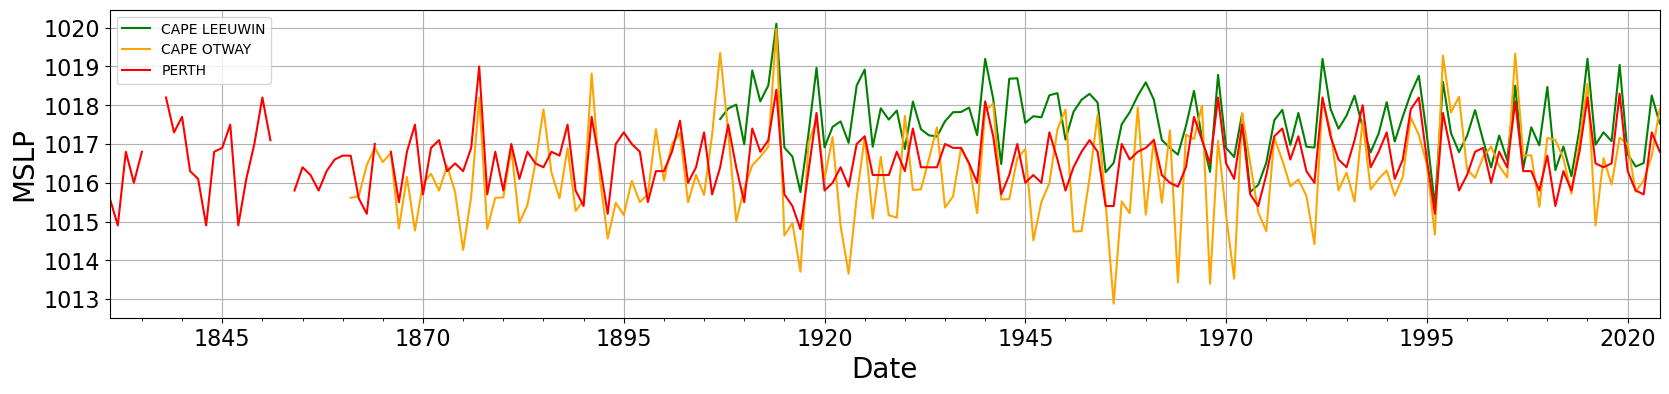

In [46]:
fig, ax= plt.subplots(1, 1, figsize=(20, 4), sharex=True)
CAPE_LEEUWIN_CORRECTED.resample('YS').mean().plot(ax = ax,color = 'green')
CAPE_OTWAY_CORRECTED.resample('YS').mean().plot(ax = ax,color = 'orange')
PERTH_YEARLY.plot(ax = ax,color = 'red')
ax.legend(['CAPE LEEUWIN','CAPE OTWAY','PERTH'])
ax.grid()
ax.set_xlabel('Date',fontsize = 20)
ax.set_ylabel('MSLP',fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

fig.savefig(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\FIGURES\PRESSURE DIFFERENT PLACES COMPARISON MSLP Comparison.png", dpi=300, bbox_inches='tight')


# 7. SAVE DATASETS

In [47]:
CAPE_OTWAY_CORRECTED.to_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\CAPE_OTWAY_PRESSURE_CORRECTED_DAILY_1861-2024.csv")
CAPE_LEEUWIN_CORRECTED.to_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\CAPE_LEEUWIN_PRESSURE_CORRECTED_SUBDAILY_1907-2024.csv")


In [48]:
CAPE_OTWAY_CORRECTED_M = ChatJR.WMO_Guide_Months(CAPE_OTWAY_CORRECTED,'Date','MSLP', False )
CAPE_LEEUWIN_CORRECTED_M = ChatJR.WMO_Guide_Months(CAPE_LEEUWIN_CORRECTED,'Date','MSLP',False)

FUNCTION_LIST.ipynb:89: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  "    - months (list of int): List of months to filter for (e.g., [1, 2, 3] for Jan, Feb, Mar).\n",
FUNCTION_LIST.ipynb:89: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  "    - months (list of int): List of months to filter for (e.g., [1, 2, 3] for Jan, Feb, Mar).\n",


In [49]:
CAPE_OTWAY_CORRECTED_M.to_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\CAPE_OTWAY_PRESSURE_CORRECTED_MONTHLY_1861-2024.csv")
CAPE_LEEUWIN_CORRECTED_M.to_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\CAPE_LEEUWIN_PRESSURE_CORRECTED_MONTHLY_1907-2024.csv")


In [50]:
P_MSLP_M = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_METRO_PRESSURE_CORRECTED_MONTHLY_1830-2024.csv").set_index('Date')
P_MSLP_M.index= pd.to_datetime(P_MSLP_M.index,format='mixed',dayfirst = True)

<Axes: xlabel='Date'>

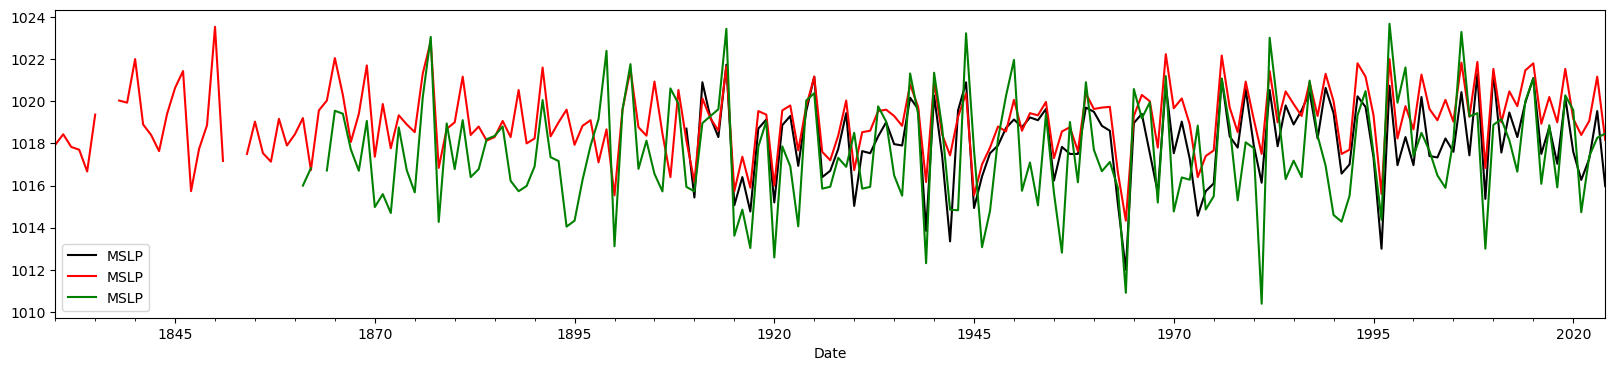

In [51]:
fig, ax= plt.subplots(1, 1, figsize=(20, 4), sharex=True)
CAPE_LEEUWIN_CORRECTED_M[(CAPE_LEEUWIN_CORRECTED_M.index.month == 6) | (CAPE_LEEUWIN_CORRECTED_M.index.month == 7) | (CAPE_LEEUWIN_CORRECTED_M.index.month == 8)].resample('YS').mean().plot(ax=ax,linestyle = '-',color= 'black')
P_MSLP_M[(P_MSLP_M.index.month == 6) | (P_MSLP_M.index.month == 7) | (P_MSLP_M.index.month == 8)].resample('YS').mean().plot(ax=ax,linestyle = '-',color= 'red')
CAPE_OTWAY_CORRECTED[(CAPE_OTWAY_CORRECTED.index.month == 6) | (CAPE_OTWAY_CORRECTED.index.month == 7) | (CAPE_OTWAY_CORRECTED.index.month == 8)].resample('YS').mean().plot(ax=ax,linestyle = '-',color= 'green')


<Axes: xlabel='Date'>

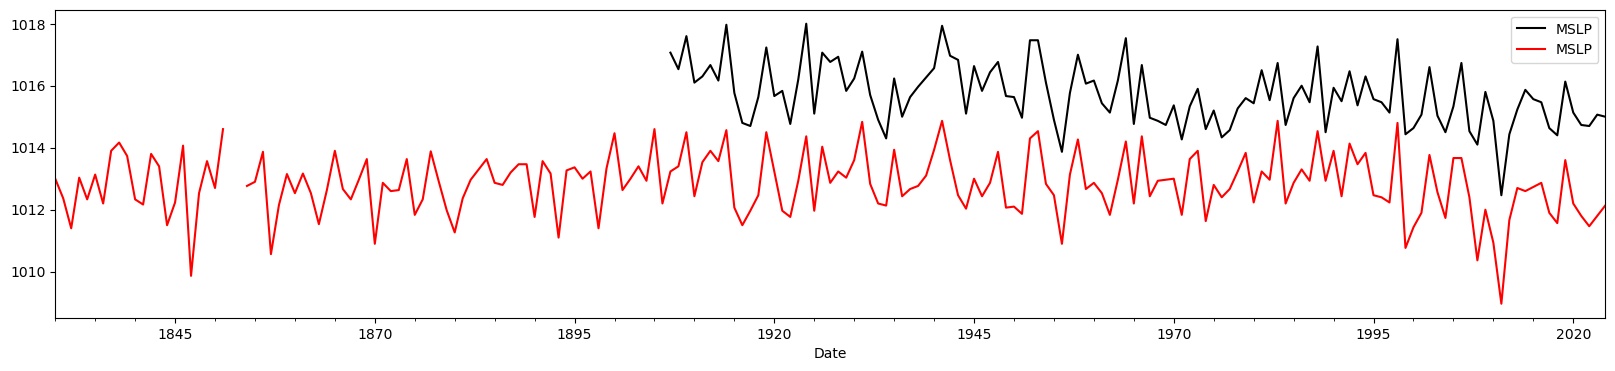

In [52]:
fig, ax= plt.subplots(1, 1, figsize=(20, 4), sharex=True)
CAPE_LEEUWIN_CORRECTED_M[(CAPE_LEEUWIN_CORRECTED_M.index.month == 12) | (CAPE_LEEUWIN_CORRECTED_M.index.month == 1) | (CAPE_LEEUWIN_CORRECTED_M.index.month == 2)].resample('YS').mean().plot(ax=ax,linestyle = '-',color= 'black')
P_MSLP_M[(P_MSLP_M.index.month == 12) | (P_MSLP_M.index.month == 1) | (P_MSLP_M.index.month == 2)].resample('YS').mean().plot(ax=ax,linestyle = '-',color= 'red')
#CAPE_OTWAY_CORRECTED[(CAPE_OTWAY_CORRECTED.index.month == 12) | (CAPE_OTWAY_CORRECTED.index.month == 1) | (CAPE_OTWAY_CORRECTED.index.month == 2)].resample('YS').mean().plot(ax=ax,linestyle = '-',color= 'green')


In [53]:
WCL = CAPE_LEEUWIN_CORRECTED_M[(CAPE_LEEUWIN_CORRECTED_M.index.month == 6) | (CAPE_LEEUWIN_CORRECTED_M.index.month == 7) | (CAPE_LEEUWIN_CORRECTED_M.index.month == 8)].resample('YS').mean()
WCLOLD = CL_MSLP[(CL_MSLP.index.month == 6) | (CL_MSLP.index.month == 7) | (CL_MSLP.index.month == 8)].resample('YS').mean()
WP = P_MSLP_M[(P_MSLP_M.index.month == 6) | (P_MSLP_M.index.month == 7) | (P_MSLP_M.index.month == 8)].resample('YS').mean()
WCO = CAPE_OTWAY_CORRECTED[(CAPE_OTWAY_CORRECTED.index.month == 6) | (CAPE_OTWAY_CORRECTED.index.month == 7) | (CAPE_OTWAY_CORRECTED.index.month == 8)].resample('YS').mean()


In [54]:
SCL = CAPE_LEEUWIN_CORRECTED[(CAPE_LEEUWIN_CORRECTED.index.month == 1) | (CAPE_LEEUWIN_CORRECTED.index.month == 2) | (CAPE_LEEUWIN_CORRECTED.index.month == 12)].resample('YS').mean()
SCLOLD = CL_MSLP[(CL_MSLP.index.month == 1) | (CL_MSLP.index.month == 2) | (CL_MSLP.index.month == 12)].resample('YS').mean()
SP = P_MSLP_M[(P_MSLP_M.index.month == 1) | (P_MSLP_M.index.month == 2) | (P_MSLP_M.index.month == 12)].resample('YS').mean()
SCO = CAPE_OTWAY_CORRECTED[(CAPE_OTWAY_CORRECTED.index.month == 2) | (CAPE_OTWAY_CORRECTED.index.month == 12) | (CAPE_OTWAY_CORRECTED.index.month == 1)].resample('YS').mean()


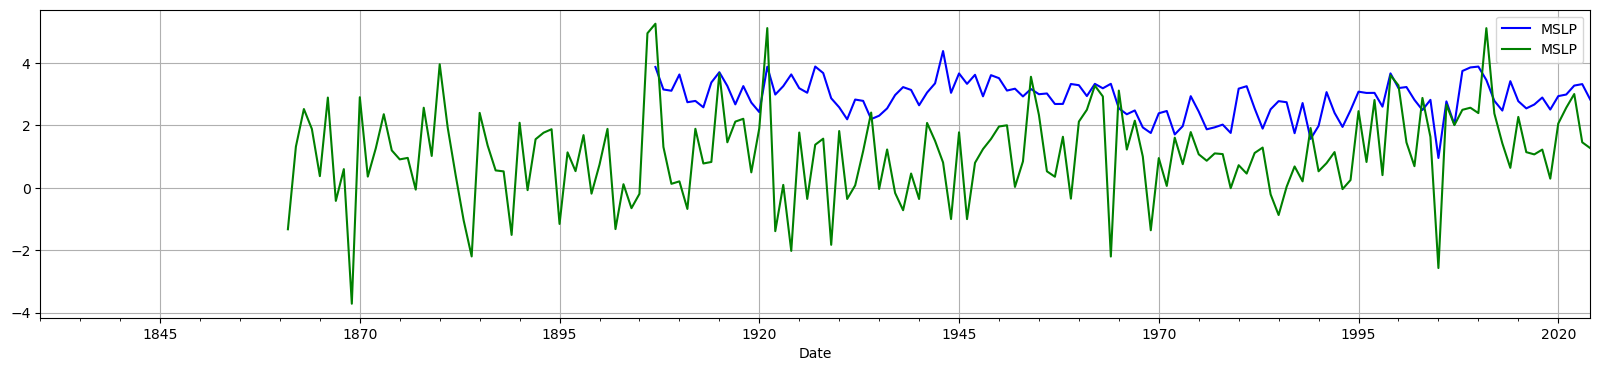

In [55]:
fig, ax= plt.subplots(1, 1, figsize=(20, 4), sharex=True)
(SCL-SP).plot(ax=ax,linestyle = '-',color= 'blue')
(SCO-SP).plot(ax=ax,linestyle = '-',color= 'green')
plt.grid()


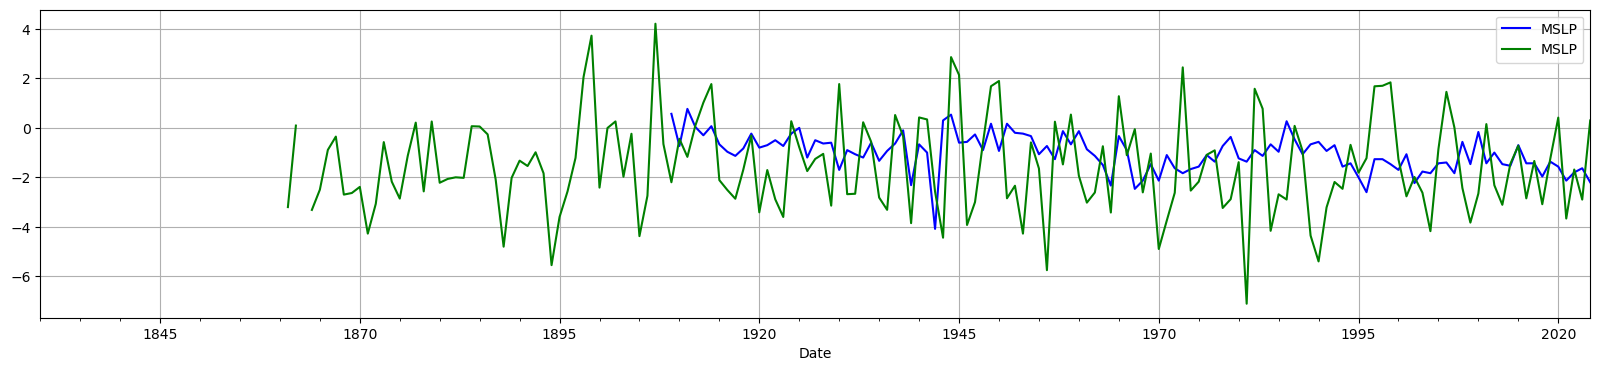

In [56]:
fig, ax= plt.subplots(1, 1, figsize=(20, 4), sharex=True)
(WCL-WP).plot(ax=ax,linestyle = '-',color= 'blue')
(WCO-WP).plot(ax=ax,linestyle = '-',color= 'green')
plt.grid()
